In [114]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [115]:
# import cucim

In [116]:
parser = argparse.ArgumentParser(description="IMDN")
parser.add_argument("--block_size", type=tuple, default=(64,64,64),
                    help="Block Size")
parser.add_argument("--crop_depth", type=int, default=30,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
args = list(parser.parse_known_args())[0]
args.preload = True
args.debug = False
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
print(args)

Namespace(batch_size=4, block_size=(64, 64, 64), crop_depth=30, debug=False, dir='/storage', preload=True, sort=True, typ='upsampled')


In [117]:
import data.HCP_dataset_h5
import utils
import data.HCP_dataset_h5_test

ids = utils.get_ids()
ids.sort()
ids = ids[:5]
training_dataset = data.HCP_dataset_h5.hcp_data(args,ids)
testing_dataset = data.HCP_dataset_h5_test.hcp_data(args,ids)

In [118]:
len(testing_dataset)

5

In [119]:
len(training_dataset)

108

In [120]:
x = testing_dataset[0]

In [121]:
x[0].shape,x[1].shape,x[2].shape,x[3].shape

((173, 207, 173, 8), (173, 207, 173), (173, 207, 173), (173, 207, 173, 3))

In [122]:
len(training_dataset)

108

In [179]:
import math
import torch.nn.functional as F
def pad(x):
        _, _, h, w = x.shape
        w_mult = ((w - 1) | 15) + 1
        h_mult = ((h - 1) | 15) + 1
        w_pad = [math.floor((w_mult - w) / 2), math.ceil((w_mult - w) / 2)]
        h_pad = [math.floor((h_mult - h) / 2), math.ceil((h_mult - h) / 2)]
        #print(w_pad,h_pad)
        # # TODO: fix this type when PyTorch fixes theirs
        # # the documentation lies - this actually takes a list
        # # https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L3457
        # # https://github.com/pytorch/pytorch/pull/16949
        x = F.pad(x, w_pad + h_pad)
        return x, (h_pad, w_pad, h_mult, w_mult)

def unpad(x,h_pad,w_pad,h_mult,w_mult):
    return x[..., h_pad[0] : h_mult - h_pad[1], w_pad[0] : w_mult - w_pad[1]]

def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0].reshape((data[i][0].shape[0]*data[i][0].shape[1],data[i][0].shape[2],data[i][0].shape[3])))
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
#         torch.cat([data[i][3],data[i][2].unsqueeze(3),data[i][1].unsqueeze(3)],axis =3))
#         print(data[i][1].shape,data[i][2].shape,data[i][3].shape)
#         y.append(np.stack([data[i][1],data[i][2],data[i][3]]))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))
import torch
import torch.nn.functional as F
import math

def ssim(img1, img2, window_size=11, window_sigma=1.5, data_range=1.0):
    # Convert the input images to tensors
    img1 = img1.float().cuda()
    img2 = img2.float().cuda()

    # Define the window used for local SSIM computation
    window = create_window(window_size, window_sigma, img1.shape[1]).cuda()

    # Compute the mean of img1 and img2
    mu1 = F.conv3d(img1, window, padding=window_size // 2, groups=img1.shape[1])
    mu2 = F.conv3d(img2, window, padding=window_size // 2, groups=img2.shape[1])

    # Compute the variance of img1 and img2
    sigma1_sq = F.conv3d(img1 * img1, window, padding=window_size // 2, groups=img1.shape[1]) - mu1 * mu1
    sigma2_sq = F.conv3d(img2 * img2, window, padding=window_size // 2, groups=img2.shape[1]) - mu2 * mu2

    # Compute the covariance of img1 and img2
    sigma12 = F.conv3d(img1 * img2, window, padding=window_size // 2, groups=img1.shape[1]) - mu1 * mu2

    # Constants for SSIM calculation
    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2

    # Compute the SSIM index
    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_index = torch.mean(ssim_map)

    return ssim_index.item()

def create_window(window_size, window_sigma, num_channels):
    # Create a 3D Gaussian window
    gauss = torch.Tensor([math.exp(-(x - window_size // 2) ** 2 / (2 * window_sigma ** 2)) for x in range(window_size)])
    gauss = gauss / gauss.sum()
    window = torch.outer(gauss, gauss).unsqueeze(0).unsqueeze(0).repeat(1, num_channels, 1, 1, 1)
    return window


In [148]:
training_dataset.blk_indx

array([ 27,  45,  63,  81, 108])

In [126]:
x = testing_dataset[0]

In [127]:
x[0].shape,x[1].shape,x[2].shape,x[3].shape

((173, 207, 173, 8), (173, 207, 173), (173, 207, 173), (173, 207, 173, 3))

In [128]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=12, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True,collate_fn=resize)

In [129]:
temp = next(iter(testing_data_loader))

In [130]:
temp[0].shape

torch.Size([1, 35811, 173, 8])

In [131]:
# torch.permute(temp[0],(0,3,1,2)).shape

In [132]:
temp[1].shape

torch.Size([1, 173, 207, 173, 5])

In [133]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=40, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [134]:
for iteration, (lr_tensor, hr_tensor) in enumerate(training_data_loader, 1):
    print(lr_tensor.shape,hr_tensor.shape)
    break

torch.Size([40, 4096, 64, 8]) torch.Size([40, 64, 64, 64, 5])


In [135]:
# from Meta_SR_Pytorch.model import metarcan 

# parser = argparse.ArgumentParser(description="metarcan")
# parser.add_argument("--reduction", type=int,
#                     help="dataset_directory")
# parser.add_argument("--n_resblocks", type=int,
#                     help="dataset_directory")
# parser.add_argument("--n_resgroups", type=int,
#                     help="dataset_directory")
# parser.add_argument("--n_feats", type=int,
#                     help="dataset_directory")
# parser.add_argument("--scale", type=int,
#                     help="dataset_directory")
# parser.add_argument("--rgb_range", type=int,
#                     help="dataset_directory")
# args = list(parser.parse_known_args())[0]
# args.reduction = 16
# args.n_resgroups = 8
# args.n_resblocks = 8
# args.n_feats = 4
# args.scale = [1.2]
# args.n_colors = 8
# args.rgb_range = 1
# args.res_scale = 1.2
# print(args)

In [136]:
# temp_model = metarcan.RCAN(args)

In [137]:
temp = next(iter(training_data_loader))
temp[0] = torch.permute(temp[0],(0,3,1,2))
temp[0].shape

torch.Size([40, 8, 4096, 64])

In [138]:
temp[1].shape

torch.Size([40, 64, 64, 64, 5])

In [149]:
from deep_cascade_caunet.models import CSEUnetModel

In [150]:
model = CSEUnetModel(in_chans = 8,out_chans = 5,chans = 4,num_pool_layers = 2,drop_prob=0.2,reduction=4)

In [151]:
out = model(temp[0])

In [152]:
out.shape

torch.Size([40, 5, 4096, 64])

In [143]:
out_temp = torch.permute(out,(0,2,3,1))

In [153]:
out_temp.shape

torch.Size([40, 4096, 64, 5])

In [154]:
out_out = out_temp.reshape(40,64,64,64,5)

In [155]:
out_out.shape

torch.Size([40, 64, 64, 64, 5])

In [ ]:
ssim(out_out[0,:,:,:,:],)

In [156]:
# import monai
# ssim = monai.losses.ssim_loss.SSIMLoss(spatial_dims =3)

In [219]:
out = model(temp[0])
out_temp = torch.permute(out,(0,2,3,1))
out_out = out_temp.reshape(40,64,64,64,5)
hr = torch.permute(temp[1],(0,4,1,2,3)).detach().numpy()
pred = torch.permute(out_out,(0,4,1,2,3)).detach().numpy()

In [220]:
pred.shape,hr.shape

((40, 5, 64, 64, 64), (40, 5, 64, 64, 64))

In [222]:
ssim

<function cucim.skimage.metrics._structural_similarity.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)>

In [228]:
import cupy as cp

In [230]:
hr = cp.array(hr)
pred = cp.array(pred)

OutOfMemoryError: Out of memory allocating 419,430,400 bytes (allocated so far: 754,977,280 bytes).

In [ ]:
ssim(hr,pred,channel_axis=1,data_range=1)

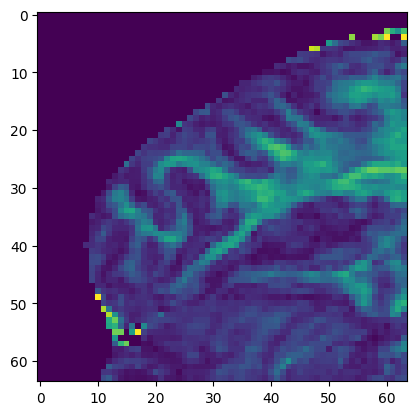

In [176]:
plt.imshow(hr[0,0,:,:,20])

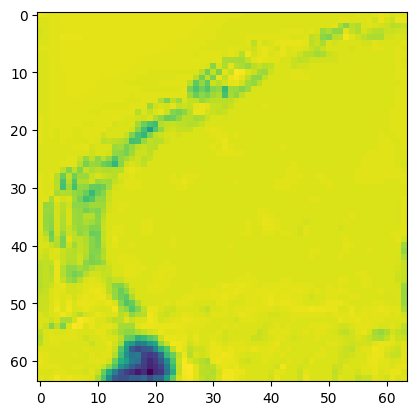

In [177]:
plt.imshow(pred[0,0,:,:,20])

In [213]:
l1_crit = nn.L1Loss().to('cuda')

In [193]:
l1_crit(hr, pred)

tensor(0.1950, dtype=torch.float64)

In [189]:
import torch
import torch.nn.functional as F
import math
def ssim(tensor1, tensor2, window_size=11, size_average=True):
    device = tensor1.device
    
    def gaussian(window_size, sigma):
        gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
        return gauss/gauss.sum()
    
    def create_window(window_size, channel):
        _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window
    
    def _ssim(img1, img2, window, window_size, channel, size_average=True):
        mu1 = F.conv3d(img1, window, padding=window_size//2, groups=channel)
        mu2 = F.conv3d(img2, window, padding=window_size//2, groups=channel)
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.conv3d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv3d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv3d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2
        
        C1 = (0.01 * 255)**2
        C2 = (0.03 * 255)**2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        if size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)
    
    channel = tensor1.size(1)
    window = create_window(window_size, channel).to(device)
    return _ssim(tensor1, tensor2, window, window_size, channel, size_average)

In [195]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

In [194]:
d

NameError: name 'd' is not defined

In [196]:
from torchmetrics.functional import structural_similarity_index_measure
preds = torch.rand([40, 5, 64, 64,64])
target = preds * 0.75

In [197]:
hr.shape

torch.Size([40, 5, 64, 64, 64])

In [198]:
hr_np = np.array(hr)
pred_np = np.array(pred.detach().numpy())

In [199]:
structural_similarity_index_measure(preds, target)

tensor(0.9219)

In [67]:
import skimage.metrics as metrics

In [72]:
hr_np.shape,pred_np.shape

((40, 5, 64, 64, 64), (40, 5, 64, 64, 64))

In [73]:
metrics.peak_signal_noise_ratio(hr_np,pred_np)

/tmp/ipykernel_978987/1053201223.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  metrics.peak_signal_noise_ratio(hr_np,pred_np)


6.55933999427658

In [79]:
hr_np.max(),hr_np.min(),pred_np.max(),pred_np.min()

(0.9999999352666846, 0.0, 1.9130101, -1.9448488)

In [83]:
from SSIM_PIL import compare_ssim

ModuleNotFoundError: No module named 'SSIM_PIL'

In [80]:
metrics.structural_similarity(hr_np,pred_np,channel_axis = 1,data_range =3.8 )

-0.11284204100749448

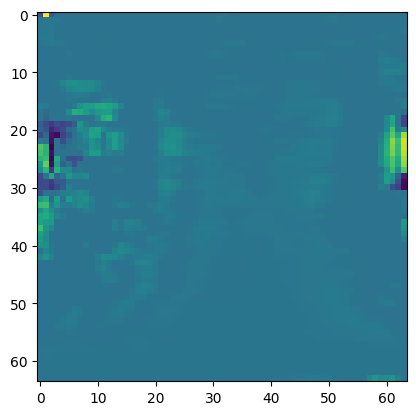

In [44]:
plt.imshow(out_out[0,:,:,20,0].detach().numpy())

In [36]:
x[0].shape,x[1].shape,x[2].shape,x[3].shape

((173, 207, 173, 8), (173, 207, 173), (173, 207, 173), (173, 207, 173, 3))

In [44]:
temp = next(iter(testing_data_loader))
temp[0] = torch.permute(temp[0],(0,3,1,2))
temp[0].shape

torch.Size([1, 8, 35811, 173])

In [46]:
t= pad(temp[0])

In [47]:
t[0].shape

torch.Size([1, 8, 35824, 176])

In [48]:
y = model(t[0])

In [49]:
y.shape

torch.Size([1, 5, 35824, 176])

In [50]:
t[1]

([6, 7], [1, 2], 35824, 176)

In [51]:
u = unpad(y,t[1][0],t[1][1],t[1][2],t[1][3])

In [52]:
u.shape

torch.Size([1, 5, 35811, 173])

In [53]:
out = u.reshape(1, 173, 207, 173, 5)
out = torch.permute(out,(0,4,1,2,3))

In [54]:
out.shape

torch.Size([1, 5, 173, 207, 173])

In [55]:
temp[1].shape
hr = torch.permute(temp[1],(0,4,1,2,3))

In [56]:
hr.shape,out.shape

(torch.Size([1, 5, 173, 207, 173]), torch.Size([1, 5, 173, 207, 173]))

In [70]:
ssim(hr,out)

tensor(1.0011, grad_fn=<MeanBackward0>)

In [64]:
from torchmetrics import StructuralSimilarityIndexMeasure
import torch
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)